# Part 2 - Multiple Scenario Analysis

<div class="alert alert-block alert-info">Before you run this notebook, you must run Part 1 - Network Design.</div>

## Set up

#### Insert a project token

When you import this project from the IBM Cloud Pak for Data/watsonx Resource hub, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'YOUR_PROJECT_TOKEN'})
```

If you do not see the cell above, follow these steps to enable the notebook to access the data set from the project's resources:

* Click `More -> Insert project token` in the top-right menu section
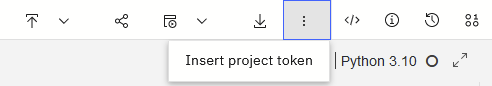

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

In [2]:
#dd-ignore
# @hidden_cell
# from ibm_watson_studio_lib import access_project_or_space
# wslib = access_project_or_space({'token':'your-access-token'})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install --upgrade decision-optimization-client

  Preparing metadata (setup.py) ... done
  Created wheel for decision-optimization-client: filename=decision_optimization_client-1.2.0-py3-none-any.whl size=32554 sha256=6150c4bf6612aa8c95bb2c20d950b9fe8a71d7ee48555703ae8260017b694733
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/84/b9/10/3e2fc51552b43415b33c1d8eab796e9aecdc80f3d88d766744
Successfully built decision-optimization-client
  Attempting uninstall: decision-optimization-client
    Found existing installation: decision_optimization_client 1.1.2
    Uninstalling decision_optimization_client-1.1.2:
      Successfully uninstalled decision_optimization_client-1.1.2


## Import the libraries

In [5]:
# This notebook requires an APIKEY to be able to use watsonx.ai Runtime to solve the different scenarios from the Decision Optimization experiment.
# To access your API key, go to cloud.ibm.com, then click Manage > Access(IAM)

apikey="<API_key>"

In [6]:
from decision_optimization_client import *

# In order to use the solve() function, you must provide an API key when creating the client
client = Client(wslib=wslib, apikey=apikey)
decision = client.get_experiment(name="NetworkDesign")
scenario = decision.get_scenario(name="Scenario 1")
df_parameters = scenario.get_table_data('PARAMETERS')
print (df_parameters)

            name  value
0   MAX_PRODUCTS      5
1  MAX_CUSTOMERS    300
2   MIN_OPEN_DCS      1
3   MAX_OPEN_DCS      3


## Analyzing multiple scenarios

In [7]:
min = 1
max = 10

for i in range(min, max+1):
    print()
    sc_name = "Fixed %02d" % (i)
    print(sc_name)
    copy = decision.get_scenario(name=sc_name)
    if (copy != None):
        print(" Deleting old...")
        decision.delete_container(copy)
    print(" Copying from original scenario...")    
    copy = scenario.copy(sc_name)
    print(" Modifying parameters...")
    df_parameters = copy.get_table_data('PARAMETERS')
    df_parameters.value[df_parameters.name=='MIN_OPEN_DCS'] = i
    df_parameters.value[df_parameters.name=='MAX_OPEN_DCS'] = i
    print (df_parameters)
    copy.add_table_data("PARAMETERS", df_parameters, category='input')
    print(" Solving...")
    copy.solve(log_output=True)
    
print("Done!")


Fixed 01
 Deleting old...
 Copying from original scenario...
 Modifying parameters...
            name  value
0   MAX_PRODUCTS      5
1  MAX_CUSTOMERS    300
2   MIN_OPEN_DCS      1
3   MAX_OPEN_DCS      1
 Solving...

Fixed 02
 Deleting old...
 Copying from original scenario...
 Modifying parameters...
            name  value
0   MAX_PRODUCTS      5
1  MAX_CUSTOMERS    300
2   MIN_OPEN_DCS      2
3   MAX_OPEN_DCS      2
 Solving...

Fixed 03
 Deleting old...
 Copying from original scenario...
 Modifying parameters...
            name  value
0   MAX_PRODUCTS      5
1  MAX_CUSTOMERS    300
2   MIN_OPEN_DCS      3
3   MAX_OPEN_DCS      3
 Solving...

Fixed 04
 Deleting old...
 Copying from original scenario...
 Modifying parameters...
            name  value
0   MAX_PRODUCTS      5
1  MAX_CUSTOMERS    300
2   MIN_OPEN_DCS      4
3   MAX_OPEN_DCS      4
 Solving...

Fixed 05
 Deleting old...
 Copying from original scenario...
 Modifying parameters...
            name  value
0   MAX_PRODU

In [8]:
import pandas as pd

min = 1
max = 10

df_all_kpis = None
print(" Aggregating solution kpis in a unique table...")
for i in range(min, max+1):
    sc_name = "Fixed %02d" % (i)
    print(sc_name)
    copy = decision.get_scenario(name=sc_name)
    df_kpis = copy.get_table_data('kpis').copy()
    df_kpis = df_kpis.rename(columns={"Value": sc_name})
    df_kpis = df_kpis.set_index("Name")
    if i==min:
        df_all_kpis = df_kpis.copy()
    else:
        df_all_kpis = df_all_kpis.join(df_kpis)
    
df_all_kpis = df_all_kpis.reset_index()
scenario.add_table_data("all_kpis", df_all_kpis, category='output')
print(df_all_kpis)



 Aggregating solution kpis in a unique table...
Fixed 01
Fixed 02
Fixed 03
Fixed 04
Fixed 05
Fixed 06
Fixed 07
Fixed 08
Fixed 09
Fixed 10
                             Name      Fixed 01      Fixed 02      Fixed 03  \
0     fixedDistributionCenterCost  5.000000e+05  1.150000e+06  1.650000e+06   
1                           _time  6.157560e-01  7.484882e+00  2.811339e+00   
2               variablePlantCost  1.582245e+07  1.673805e+07  1.659650e+07   
3      outboundTransportationCost  3.348924e+07  1.248027e+07  1.074761e+07   
4      PROGRESS_CURRENT_OBJECTIVE  5.441756e+07  3.980812e+07  3.677869e+07   
5       nbOpenDistributionCenters  1.000000e+00  2.000000e+00  3.000000e+00   
6       inboundTransportationCost  1.928864e+06  6.762801e+06  5.107575e+06   
7  variableDistributionCenterCost  2.677000e+06  2.677000e+06  2.677000e+06   

       Fixed 04      Fixed 05      Fixed 06      Fixed 07      Fixed 08  \
0  2.150000e+06  2.600000e+06  3.250000e+06  3.700000e+06  4.200000e+06   


## Aggregating solutions

In [9]:
import pandas as pd

min = 1
max = 10

df_all_kpis_2 = pd.DataFrame()
print(" Aggregating solution kpis in a unique table...")
for i in range(min, max+1):
    sc_name = "Fixed %02d" % (i)
    print(sc_name)
    copy = decision.get_scenario(name=sc_name)
    df_kpis = copy.get_table_data('kpis').copy()
    df_kpis['Scenario'] = sc_name
    df_kpis = df_kpis.rename(columns={"Value": sc_name})
    df_kpis = df_kpis.pivot(index="Scenario", columns="Name", values=sc_name)
    #print (df_kpis)
    df_all_kpis_2 = pd.concat([df_all_kpis_2, df_kpis])
    
df_all_kpis_2 = df_all_kpis_2.reset_index()
scenario.add_table_data("all_kpis_2", df_all_kpis_2, category='output')
print(df_all_kpis_2)

 Aggregating solution kpis in a unique table...
Fixed 01
Fixed 02
Fixed 03
Fixed 04
Fixed 05
Fixed 06
Fixed 07
Fixed 08
Fixed 09
Fixed 10
Name  Scenario  PROGRESS_CURRENT_OBJECTIVE     _time  \
0     Fixed 01                 54417555.84  0.615756   
1     Fixed 02                 39808117.34  7.484882   
2     Fixed 03                 36778688.62  2.811339   
3     Fixed 04                 36557662.93  2.394108   
4     Fixed 05                 36388595.67  1.829777   
5     Fixed 06                 36263685.18  1.775675   
6     Fixed 07                 36287529.66  1.222850   
7     Fixed 08                 36443826.06  1.269573   
8     Fixed 09                 36631525.63  0.794847   
9     Fixed 10                 36900459.55  0.550060   

Name  fixedDistributionCenterCost  inboundTransportationCost  \
0                        500000.0                 1928864.40   
1                       1150000.0                 6762800.76   
2                       1650000.0                 510

## Summary

Congratulations! You have learned how to:

1. Load and prepare network design data
2. Create a decision optimization model
3. Configure the KPIs, constraints and objectives
4. Solve the optimization problem
5. Create and analyze multiple scenarios
6. Load the solutions into a Decision Optimization experiment

To see the results, go to the project home and click `NetworkDesign` under Decision Optimization experiment.

<hr>
Copyright © 2021-2025 IBM. This notebook and its source code are released under the terms of the MIT License.